In [1]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

random.seed(0)

print("Running...")


thr_std=0.2

E = Events("CheatedRecoFile_1.root")

view_u = View(E, "u")
view_v = View(E, "v")
view_w = View(E, "w")

u_x = view_u.x
u_z = view_u.z
u_adc = view_u.adc
u_truevtx_z = view_u.true_vtx_z
u_truevtx_x = view_u.true_vtx_x

v_x = view_v.x
v_z = view_v.z
v_adc = view_v.adc
v_truevtx_z = view_v.true_vtx_z
v_truevtx_x = view_v.true_vtx_x

w_x = view_w.x
w_z = view_w.z
w_adc = view_w.adc
w_truevtx_z = view_w.true_vtx_z
w_truevtx_x = view_w.true_vtx_x



Running...


In [2]:
print(len(u_x))

9310


In [3]:
def AoI(plane, event_number, thresholding=True, no_std=thr_std):
    if plane=="u":
        AoI_x = u_x[event_number]
        AoI_z = u_z[event_number]
        AoI_adc = u_adc[event_number]
        AoI_truevtxz = u_truevtx_z[event_number]
        AoI_truevtxx = u_truevtx_x[event_number]
    elif plane=="v":
        AoI_x = v_x[event_number]
        AoI_z = v_z[event_number]
        AoI_adc = v_adc[event_number]
        AoI_truevtxz = v_truevtx_z[event_number]
        AoI_truevtxx = v_truevtx_x[event_number]
    elif plane=="w":
        AoI_x = w_x[event_number]
        AoI_z = w_z[event_number]
        AoI_adc = w_adc[event_number]   
        AoI_truevtxz = w_truevtx_z[event_number]
        AoI_truevtxx = w_truevtx_x[event_number]
    else:
        print("PLane not u,v,w")
        
    if thresholding:
        mean = np.average(AoI_adc)
        std = np.std(AoI_adc)
        AoI_x = AoI_x[(mean-no_std*std<AoI_adc)]
        AoI_z = AoI_z[(mean-no_std*std<AoI_adc)]
        AoI_adc = AoI_adc[(mean-no_std*std<AoI_adc)]
    
    return AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx

In [4]:
def plotter(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)


    
    plt.scatter(AoI_z, AoI_x, c=AoI_adc, cmap="viridis")
    plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")

    return 0


In [5]:
def least_z(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    min_z = np.amin(AoI_z)
    ind = np.where(min_z)[0]
    min_x = AoI_x[ind]
    #print("Least z prediction for vertex location: (x-position, z-position, plane)=", min_x, min_z, plane)
    return min_z, min_x

In [6]:
def phi_hist(plane, event_number, thresholding=True, no_std=thr_std, leastz=False, centre_coord=(0,0), no_sectors=12, centre=0, printhist=False):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    if leastz:
        centre_coord = least_z(plane, event_number, thresholding, no_std)
    
    
    centred_x = AoI_x - centre_coord[1]
    centred_z = AoI_z - centre_coord[0]

    theta = np.arctan2(centred_x, centred_z)
    hist_data, hist_bins = np.histogram(theta, no_sectors, (-np.pi+centre,np.pi+centre))
    
    hist_sqr = hist_data**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    
    if printhist:
        plt.hist(hist_data, hist_bins)
        plt.show()

    return norm_score

In [7]:
def rfunc(r):
    return 1/((r+0.01)**(1/2))



def rphi(plane, event_number, thresholding=True, no_std=thr_std, centre_coord=(0,0), func=rfunc, no_sectors=5, centre=0):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    centred_x = AoI_x - centre_coord[1]
    centred_z = AoI_z - centre_coord[0]
    
    cen_r = (centred_x**2 + centred_z**2)**0.5
    #distance from central point to every other point
    

    #make the problem tractable (solvable)
    
    weight = rfunc(cen_r)

    theta = np.arctan2(centred_x, centred_z)
    hist_data, hist_bins = np.histogram(theta, no_sectors, (-np.pi+centre,np.pi+centre), weights=weight)
    
    hist_sqr = hist_data**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    

    return norm_score

In [8]:
def optimise_phi(plane, event_number, thresholding=True, no_std=thr_std, no_sectors=20, centre=0, plot=False):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    no_points = len(AoI_x)
    score_arr = np.zeros(no_points)
    for i in range(no_points):
        centre_co = (AoI_z[i], AoI_x[i])
        score_arr[i] = rphi(plane, event_number, centre_coord=centre_co)
    
    ind = np.argmax(score_arr)
    zmin, xmin = AoI_z[ind], AoI_x[ind]
    if plot:
        plotter(plane, event_number, thresholding, no_std)
        plt.plot(zmin, xmin, 'ro')
        plt.show()
    return zmin, xmin, score_arr[ind], score_arr

In [9]:
def accuracy(plane, function, no_events, thresholding=True, no_std=thr_std, ifrandom=True):
    Zvert = []
    Zvert_true = []
    Xvert = []
    Xvert_true = [] #avoid appends to lists; if you know how long the outputs are going to be, then assign the arrays to
                    #that length beforehand
    if ifrandom:
        for i in tqdm(range(no_events)):   
            j = random.randint(0, len(u_x))
            AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, j, thresholding, no_std)
            Zvert_place, Xvert_place = function(plane, j)[0], function(plane, j)[1]
            Zvert.append(Zvert_place)
            Xvert.append(Xvert_place)
            Zvert_true.append(Zvert_true_place)
            Xvert_true.append(Xvert_true_place)
    else:
        for i in tqdm(range(no_events)):
            AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, i, thresholding, no_std)
            Zvert_place, Xvert_place = function(plane, i)[0], function(plane, i)[1]
            Zvert.append(Zvert_place)
            Xvert.append(Xvert_place)
            Zvert_true.append(Zvert_true_place)
            Xvert_true.append(Xvert_true_place)
    
    '''
    print(Zvert_true)
    print(Zvert)
    print(Xvert_true)
    print(Xvert)
    '''
    
    delta_z = np.array(Zvert_true) - np.array(Zvert)
    delta_x = np.array(Xvert_true) - np.array(Xvert)
    delta_r2 = delta_z**2 + delta_x**2

    print(len(delta_r2))
    print(delta_r2)
    
    #data, bins = np.histogram(delta_r2)
    #delta_r2 = delta_r2[delta_r2 < 0.4e6]
    delta_r2 = np.sqrt(delta_r2)
    plt.hist(delta_r2, bins='auto')
    #plt.ylim(0, 400)
    plt.show()

    return delta_r2, np.percentile(delta_r2, 68)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:53<00:00,  4.28it/s]


1000
[9.01789648e+03 6.17829084e-01 4.66877594e+02 4.59727295e+03
 6.49721832e+01 1.64966919e+02 6.05047656e+04 5.04015684e-01
 1.19165106e+01 5.61594910e+02 7.72832947e+01 7.88170472e-03
 1.08266985e-02 1.11700708e+03 1.41234436e+02 2.25314545e+02
 5.27867031e+00 2.18303032e+01 1.23073767e+03 8.42751789e+00
 1.04773976e-02 1.55788153e-01 1.14492480e+03 8.36317921e+00
 2.36154272e+03 6.29033630e+02 3.18874500e+05 4.71851873e+00
 6.09414062e+01 4.38054657e+00 2.94701025e+03 6.42461609e+02
 2.21809477e-01 8.80767480e+03 3.49474335e+02 1.69883008e+03
 6.92683716e+01 7.83802652e+00 4.69089297e+04 2.18273373e+01
 1.97824979e+00 1.02806055e+03 2.87884216e+01 1.15251294e+03
 2.66535126e+02 2.52445374e+01 1.32591895e+03 6.43455688e+02
 4.62758887e+03 1.93701005e+00 6.43506622e+01 6.98316050e+00
 1.21095772e+01 3.27230200e+03 7.83024597e+01 8.77102112e+02
 5.27337646e+02 1.09466699e+04 1.39595618e+03 6.56750879e+03
 7.62334645e-01 2.07164001e+01 2.63140742e+04 3.54060669e+03
 8.24892334e+02 1.4

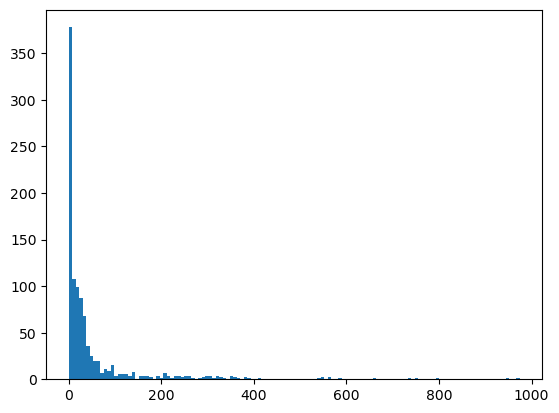

In [10]:
datadata, datadata2 = accuracy("v", optimise_phi, 1000)

In [11]:
print(datadata2)

31.431131820678715


In [12]:
def rphi_scores(plane, event_number, function=optimise_phi, dependence=np.exp, plot=False, thresholding=True, no_std=thr_std, no_sectors=5):
    AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, event_number, thresholding, no_std)
    Zvert_place, Xvert_place = function(plane, event_number, no_sectors)[0], function(plane, event_number, no_sectors)[1]
    score_max, score_array = function(plane, event_number, no_sectors)[2], function(plane, event_number, no_sectors)[3]
    
    score_min = np.min(score_array)
    
    normalised_scores = (score_array - score_min) / (score_max - score_min)
    
    if plot:
        plt.plot(AoI_z, AoI_x, 'o')
        plt.show()
        plt.plot(AoI_z, normalised_scores, 'ro')
        plt.show()
    return normalised_scores

In [58]:
def pdf_rphi(plane, events, plot=False):
    
    total_signal = []
    total_back = []
    total_r_sig = []
    total_r_back = []
    
    for ev in tqdm(events):
        signal_indexes = []
        back_indexes = []
        AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, ev)
        Zvert_place, Xvert_place = optimise_phi(plane, ev)[0], optimise_phi(plane, ev)[1]
        
        normalised_score = rphi_scores(plane, ev)
        
        #print("\nNormalised Score: ", normalised_score)
        signal = normalised_score[normalised_score >= 0.85]
        #print("\nSignal: ", signal)
        background = normalised_score[normalised_score < 0.85]
        #print("\nBackground: ", background)
        
        r = [None] * len(AoI_z)
        
        for i in range(len(AoI_z)):
            r[i] = ( (AoI_z[i]-Zvert_place)**2 + (AoI_x[i]-Xvert_place)**2 )**0.5
        #print("\nLen R:", len(r))
        for jx in range(len(signal)):
            index_sig = np.where(normalised_score == signal[jx])
            signal_indexes.append(index_sig[0][0])

        for jy in range(len(background)):
            index_back = np.where(normalised_score == background[jy])
            back_indexes.append(index_back[0][0])
        
        #print("\nSignal Indexes:", signal_indexes)
        #print("\nBack Indexes:", back_indexes)
        
        r_signal_test = [r[i] for i in signal_indexes]
        r_background_test = [r[i] for i in back_indexes]
        
        '''
        if plot:
            x = plt.hist(signal,30, color='b')
            y = plt.hist(background,30, color='r')
            plt.show()
            
            z = plt.hist(r_signal_test,30, color='c')
            zz = plt.hist(r_background_test,30, color='y')
            plt.show()
        '''
        
        total_signal.extend(signal)
        total_back.extend(background)
        total_r_sig.extend(r_signal_test)
        total_r_back.extend(r_background_test)
    #print("Total Signal: ", r_signal_test)
    total_r_back = [item for item in total_r_back if item < 400]
    if plot:
        data = plt.hist(total_signal, 50)[0]
        weights_signal_single = 1/np.max(data)
        weights_signal = np.full(shape = len(total_signal), fill_value = weights_signal_single)
        data2 = plt.hist(total_back, 50)[0]
        weights_back_single = 1/np.max(data2)
        weights_back = np.full(shape = len(total_back), fill_value = weights_back_single)
        plt.clf()
        
        x = plt.hist(total_signal,30, color='b', alpha=0.5, weights=weights_signal)
        y = plt.hist(total_back,50, color='r', alpha=0.5, weights=weights_back)
        title = plt.title("Signal / Background Split")
        plt.show()
        
        data3 = plt.hist(total_r_sig, 50)[0]
        weights_r_signal_single = 1/np.max(data3)
        weights_r_signal = np.full(shape = len(total_r_sig), fill_value = weights_r_signal_single)
        data4 = plt.hist(total_r_back, 50)[0]
        weights_r_back_single = 1/np.max(data4)
        weights_r_back = np.full(shape = len(total_r_back), fill_value = weights_r_back_single)
        plt.clf()
        
        z = plt.hist(total_r_sig,50, color='c', alpha=0.5, weights=weights_r_signal)
        zz = plt.hist(total_r_back,50, color='y', alpha=0.5, weights=weights_r_back)
        title = plt.title("Signal / Background Split in RSqr Values")
        plt.show()
        
    return x, y
        
sample = random.sample(range(0, len(u_x)), 1000)

#pdf_rphi("u", sample, plot=True)

In [59]:
interaction_dictionary = {}

import pandas as pd
import csv

with open('interactions.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        key = int(row.pop('Idx'))
        interaction = row.pop('Interaction')
        interaction_dictionary[key] = interaction

In [60]:
def interaction_finder(events):
    all_events = np.unique(events.event_number)
    x = [ events.interaction_type[np.where(events.event_number == e)] for e in all_events ]
    return x

In [61]:
interaction_type_array = interaction_finder(E)

In [62]:
import pandas as pd
import numpy as np
print(len(interaction_type_array))
print(interaction_type_array[2])

9310
[19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19]


In [63]:
def interaction_selector(interaction_dictionary):
    #CC and NC Split
    CC_indexes = []
    NC_indexes = []
    QEL_indexes = []
    DIS_indexes = []
    RES_indexes = []
    EL_indexes = []
    MU_indexes = []
    
    for i in range(len(interaction_dictionary)):
        first_two = (interaction_dictionary[i])[:2]
        if first_two == 'CC':
            CC_indexes.append(i)
        elif first_two == 'NC':
            NC_indexes.append(i)
            
    for i in range(len(interaction_dictionary)):
        first_three = (interaction_dictionary[i])[2:5]
        if first_three == 'QEL':
            QEL_indexes.append(i)
        elif first_three == 'DIS':
            DIS_indexes.append(i)
        elif first_three == 'RES':
            RES_indexes.append(i)
            
    for i in range(len(interaction_dictionary)-2):
        first_one = (interaction_dictionary[i])[6:7]
        if first_one == 'M':
            MU_indexes.append(i)
        elif first_one == 'E':
            EL_indexes.append(i)
        
    return CC_indexes, NC_indexes, QEL_indexes, DIS_indexes, RES_indexes, EL_indexes, MU_indexes

CC_indexes, NC_indexes, QEL_indexes, DIS_indexes, RES_indexes, EL_indexes, MU_indexes = interaction_selector(interaction_dictionary)

In [64]:
def interaction_splitting(interaction_type_array):
    CC_splitting = []
    NC_splitting = []
    QEL_splitting = []
    DIS_splitting = []
    RES_splitting = []
    EL_splitting = []
    MU_splitting = []

    for i in range(len(interaction_type_array)):
        if int(interaction_type_array[i][0]) in CC_indexes:
            CC_splitting.append(i)
        if int(interaction_type_array[i][0]) in NC_indexes:
            NC_splitting.append(i)
        if int(interaction_type_array[i][0]) in QEL_indexes:
            QEL_splitting.append(i)
        if int(interaction_type_array[i][0]) in RES_indexes:
            RES_splitting.append(i)
        if int(interaction_type_array[i][0]) in DIS_indexes:
            DIS_splitting.append(i)
        if int(interaction_type_array[i][0]) in MU_indexes:
            MU_splitting.append(i)
        if int(interaction_type_array[i][0]) in EL_indexes:
            EL_splitting.append(i)
        
    return CC_splitting, NC_splitting, QEL_splitting, DIS_splitting, RES_splitting, EL_splitting, MU_splitting

split_indexes = interaction_splitting(interaction_type_array)


100%|██████████████████████████████████████████████████████████████████████████████| 1504/1504 [08:37<00:00,  2.91it/s]


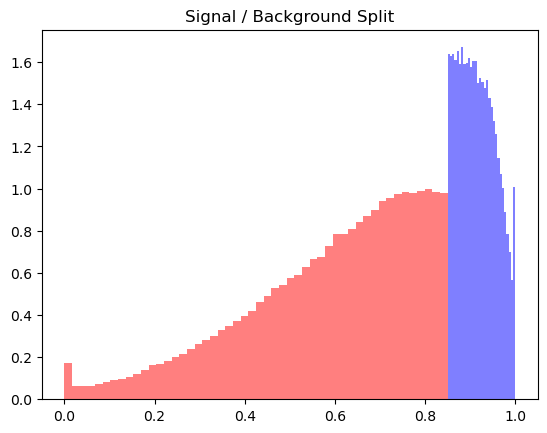

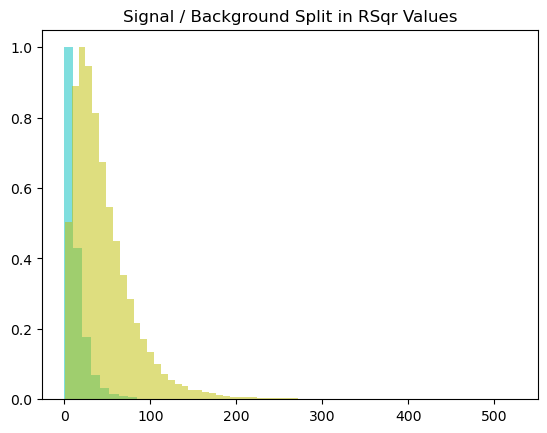

((array([1.63932496, 1.62951334, 1.6377551 , 1.60949765, 1.65188383,
         1.58908948, 1.67072214, 1.58948195, 1.59654631, 1.62087912,
         1.57770801, 1.60596546, 1.60635793, 1.49882261, 1.5255102 ,
         1.50470958, 1.47841444, 1.51687598, 1.42896389, 1.38500785,
         1.32260597, 1.25863422, 1.14678179, 1.07064364, 1.00117739,
         0.89050235, 0.78532182, 0.69858713, 0.56789639, 1.00549451]),
  array([0.85000085, 0.85500082, 0.86000079, 0.86500077, 0.87000074,
         0.87500071, 0.88000068, 0.88500065, 0.89000062, 0.8950006 ,
         0.90000057, 0.90500054, 0.91000051, 0.91500048, 0.92000045,
         0.92500043, 0.9300004 , 0.93500037, 0.94000034, 0.94500031,
         0.95000028, 0.95500026, 0.96000023, 0.9650002 , 0.97000017,
         0.97500014, 0.98000011, 0.98500009, 0.99000006, 0.99500003,
         1.        ]),
  <BarContainer object of 30 artists>),
 (array([0.1724813 , 0.064462  , 0.06320352, 0.06131581, 0.07327134,
         0.08054254, 0.09172901, 0.096

In [67]:
pdf_rphi("u", split_indexes[5], plot=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2074/2074 [17:09<00:00,  2.01it/s]


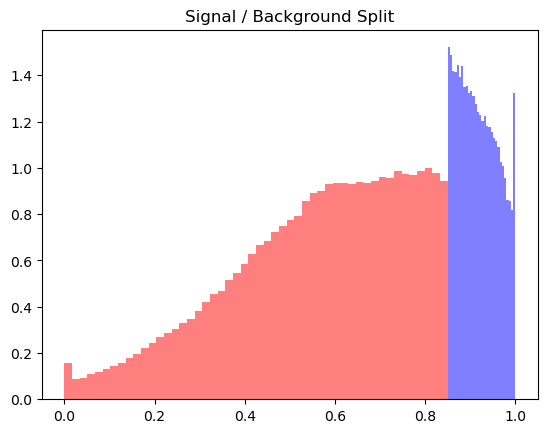

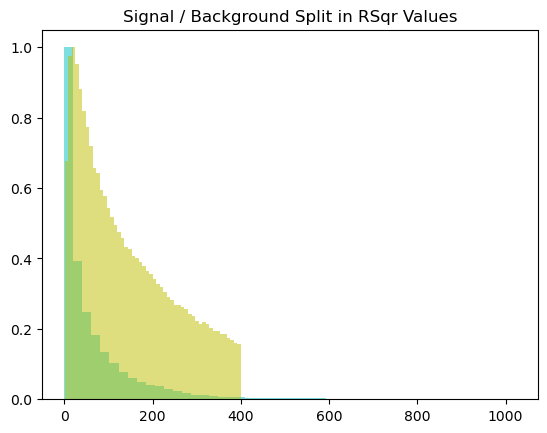

((array([1.52070588, 1.48564706, 1.41647059, 1.41270588, 1.44305882,
         1.39411765, 1.44117647, 1.35058824, 1.35552941, 1.32235294,
         1.33035294, 1.31011765, 1.276     , 1.24117647, 1.22611765,
         1.20282353, 1.22211765, 1.17905882, 1.17529412, 1.15529412,
         1.12729412, 1.11435294, 1.09105882, 1.02423529, 1.00964706,
         0.95482353, 0.86235294, 0.85811765, 0.81858824, 1.32117647]),
  array([0.8500013 , 0.85500126, 0.86000121, 0.86500117, 0.87000113,
         0.87500108, 0.88000104, 0.885001  , 0.89000095, 0.89500091,
         0.90000087, 0.90500082, 0.91000078, 0.91500074, 0.92000069,
         0.92500065, 0.93000061, 0.93500056, 0.94000052, 0.94500048,
         0.95000043, 0.95500039, 0.96000035, 0.9650003 , 0.97000026,
         0.97500022, 0.98000017, 0.98500013, 0.99000009, 0.99500004,
         1.        ]),
  <BarContainer object of 30 artists>),
 (array([0.15639085, 0.08567905, 0.09141934, 0.10808742, 0.11807977,
         0.13270686, 0.14482524, 0.157

In [68]:
pdf_rphi("u", split_indexes[6], plot=True)